In [ ]:
from src.model import VAE
from src.trainer import CLEARVAETrainer, HierachicalVAETrainer
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [4]:
np.random.seed(101)
torch.manual_seed(101)

In [5]:
from src.utils import StyledMNISTGenerator, StyledMNIST

generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3820.12item/s]


In [6]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [1e2, 1e2]
LABEL_FLIPPING = True

clear_vae = VAE(total_z_dim=Z_DIM).to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(clear_vae.parameters(), lr=1e-3)
clear_trainer = CLEARVAETrainer(
    clear_vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [7]:
clear_trainer.fit(31, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 94.32it/s] 


val_recontr_loss=52.845, val_kl_c=13.831, val_kl_s=15.745, val_c_loss=0.218, val_s_loss=0.112
gMIG: 0.207; elbo: -82.421


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 224.00it/s]


val_recontr_loss=26.271, val_kl_c=13.849, val_kl_s=20.108, val_c_loss=0.104, val_s_loss=0.110
gMIG: 0.264; elbo: -60.228


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 236.87it/s]


val_recontr_loss=22.319, val_kl_c=14.294, val_kl_s=19.735, val_c_loss=0.093, val_s_loss=0.109
gMIG: 0.277; elbo: -56.348


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 234.71it/s]


val_recontr_loss=19.784, val_kl_c=15.005, val_kl_s=20.437, val_c_loss=0.087, val_s_loss=0.109
gMIG: 0.282; elbo: -55.226


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 205.58it/s]


val_recontr_loss=18.166, val_kl_c=15.581, val_kl_s=20.318, val_c_loss=0.079, val_s_loss=0.110
gMIG: 0.292; elbo: -54.064


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 239.86it/s]


val_recontr_loss=17.404, val_kl_c=16.296, val_kl_s=21.234, val_c_loss=0.080, val_s_loss=0.109
gMIG: 0.294; elbo: -54.933


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 240.00it/s]


val_recontr_loss=16.933, val_kl_c=16.483, val_kl_s=21.010, val_c_loss=0.090, val_s_loss=0.109
gMIG: 0.287; elbo: -54.426


In [ ]:
Z_DIM = 16

ml_vae = VAE(total_z_dim=Z_DIM, group_mode="MLVAE").to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(ml_vae.parameters(), lr=1e-3)
ml_trainer = HierachicalVAETrainer(
    ml_vae,
    optimizer,
    hyperparameter={"beta": 1 / 8, "loc": 0, "scale": 1},
    verbose_period=5,
    device=device,
)

In [9]:
ml_trainer.fit(31, train_loader, valid_loader, with_evidence_acc=True)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 119.80it/s]


val_recontr_loss=52.894, val_kl_c=19.879, val_kl_s=14.867
gMIG: 0.405; elbo: -87.64


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 123.95it/s]


val_recontr_loss=25.991, val_kl_c=19.916, val_kl_s=17.302
gMIG: 0.478; elbo: -63.209


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 120.03it/s]


val_recontr_loss=22.464, val_kl_c=21.105, val_kl_s=18.774
gMIG: 0.508; elbo: -62.343


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 115.68it/s]


val_recontr_loss=20.899, val_kl_c=20.835, val_kl_s=18.794
gMIG: 0.523; elbo: -60.528


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 116.26it/s]


val_recontr_loss=20.279, val_kl_c=21.272, val_kl_s=19.358
gMIG: 0.526; elbo: -60.909


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 112.21it/s]


val_recontr_loss=19.512, val_kl_c=21.371, val_kl_s=19.083
gMIG: 0.538; elbo: -59.966


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 112.90it/s]


val_recontr_loss=19.051, val_kl_c=21.709, val_kl_s=19.878
gMIG: 0.543; elbo: -60.638


In [ ]:
Z_DIM = 16

gvae = VAE(total_z_dim=Z_DIM, group_mode="GVAE").to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(gvae.parameters(), lr=1e-3)
g_trainer = HierachicalVAETrainer(
    gvae,
    optimizer,
    hyperparameter={"beta": 1 / 8, "loc": 0, "scale": 1},
    verbose_period=5,
    device=device,
)

In [11]:
g_trainer.fit(31, train_loader, valid_loader, with_evidence_acc=True)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 118.48it/s]


val_recontr_loss=50.391, val_kl_c=19.327, val_kl_s=16.446
gMIG: 0.383; elbo: -86.164


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 118.52it/s]


val_recontr_loss=25.269, val_kl_c=21.635, val_kl_s=18.198
gMIG: 0.482; elbo: -65.103


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 115.60it/s]


val_recontr_loss=21.755, val_kl_c=21.594, val_kl_s=18.867
gMIG: 0.494; elbo: -62.217


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 105.93it/s]


val_recontr_loss=20.277, val_kl_c=20.872, val_kl_s=19.208
gMIG: 0.492; elbo: -60.356


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 116.35it/s]


val_recontr_loss=19.779, val_kl_c=22.257, val_kl_s=19.794
gMIG: 0.51; elbo: -61.829


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 122.26it/s]


val_recontr_loss=18.834, val_kl_c=21.747, val_kl_s=20.109
gMIG: 0.513; elbo: -60.689


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 120.77it/s]


val_recontr_loss=18.432, val_kl_c=21.045, val_kl_s=20.478
gMIG: 0.509; elbo: -59.955


In [12]:
from expr.visual_utils import feature_swapping_plot, interpolation_plot

### clear-vae

In [13]:
torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
clear_vae.eval()
X_hat, latent_params, z = clear_vae(X.clone(), explicit=True)


In [14]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

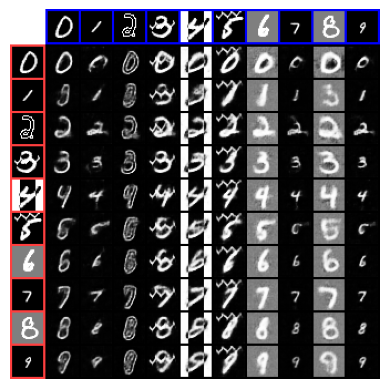

In [15]:
# illustration using all c
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], clear_vae)


In [16]:
# illustration using all s
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape

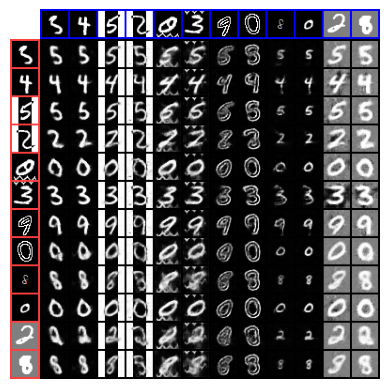

In [17]:
feature_swapping_plot(z_c, z_s, X[img_idx], clear_vae)

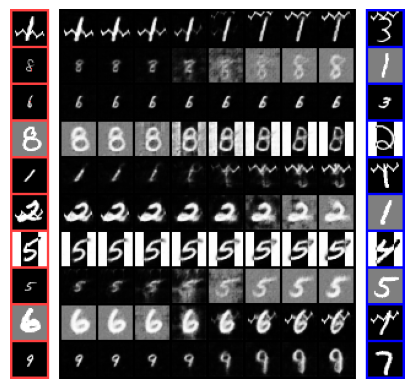

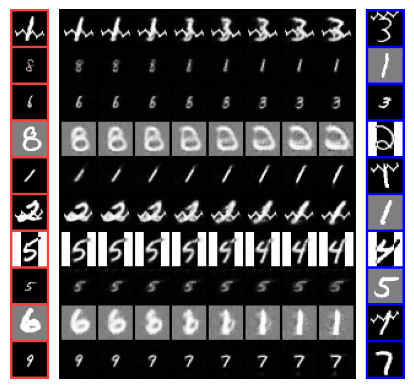

In [18]:
torch.manual_seed(1111)
np.random.seed(1111)
interpolation_plot(X, z, clear_vae, int(Z_DIM / 2), inter_steps=8)

### ml-vae

In [19]:
torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
ml_vae.eval()
X_hat_acc, latent_params_acc, z_acc = ml_vae(X.clone(), explicit=True)
X_hat_nacc, latent_params_nacc, z_nacc = ml_vae(X.clone(), c, explicit=True)

In [20]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

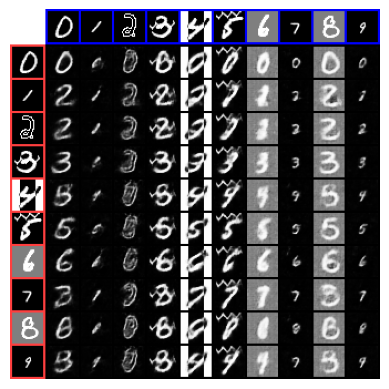

In [21]:
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], ml_vae)

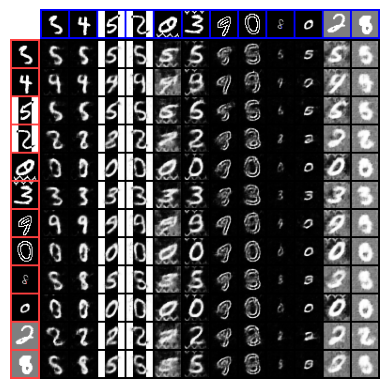

In [22]:
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], ml_vae)

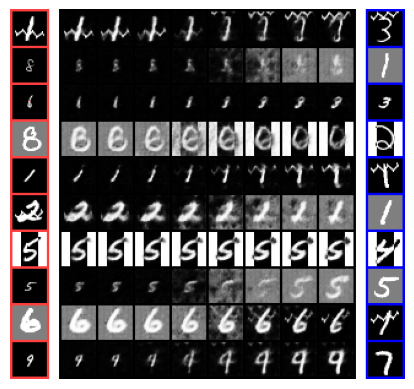

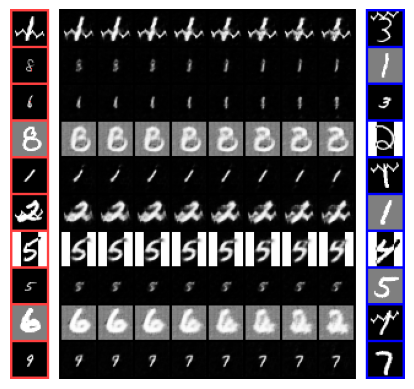

In [23]:
torch.manual_seed(1111)
np.random.seed(1111)
interpolation_plot(X, z_acc, ml_vae, int(Z_DIM / 2), inter_steps=8)

### gvae

In [24]:
torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
gvae.eval()
X_hat_acc, latent_params_acc, z_acc = gvae(X.clone(), explicit=True)
X_hat_nacc, latent_params_nacc, z_nacc = gvae(X.clone(), c, explicit=True)

In [25]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

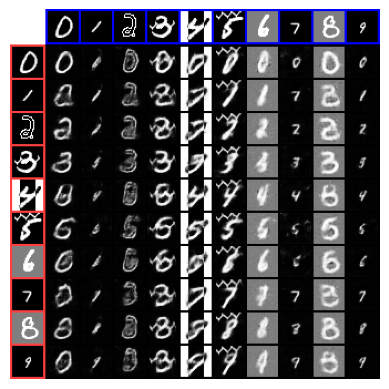

In [29]:
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], gvae)

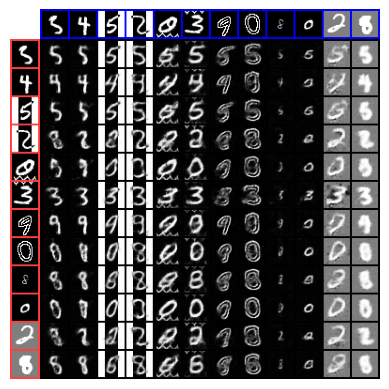

In [30]:
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], gvae)

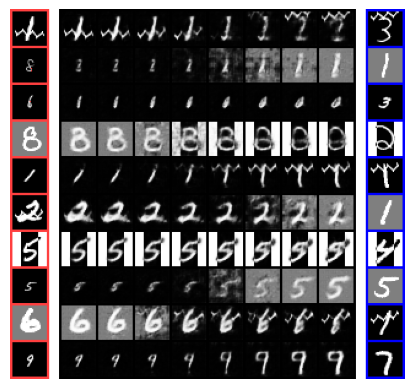

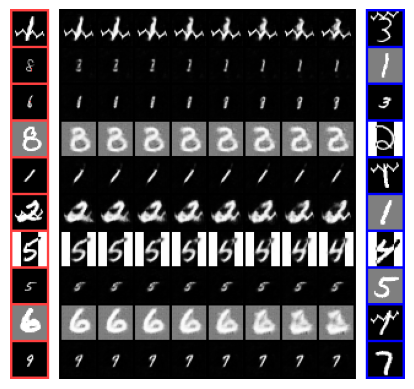

In [31]:
torch.manual_seed(1111)
np.random.seed(1111)
interpolation_plot(X, z_acc, gvae, int(Z_DIM / 2), inter_steps=8)